# Ejercicio Regression Tree
Son datos de temperaturas tomados de la ciudad de Seattle. El objetivo es intentar predecir lo mejor posible la máxima temperatura (columna `actual`) que alcanzaremos al día siguiente. Para ello contaremos con temperaturas de los dos días anteriores, históricos de máximas temperaturas y un amigo bastante chapas que te da su predicción del tiempo cada día.

**Resumen de datos**:
* year: 2016 for all data points
* month: number for month of the year
* day: number for day of the year
* week: day of the week as a character string
* temp_2: max temperature 2 days prior
* temp_1: max temperature 1 day prior
* average: historical average max temperature
* actual: max temperature measurement
* friend: your friend’s prediction, a random number between 20 below the average and 20 above the average


### 1. Importa el csv "temps.csv"

In [162]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor,plot_tree
from sklearn.model_selection import GridSearchCV, train_test_split,cross_val_score
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error,precision_score,recall_score,f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

In [26]:
df = pd.read_csv("temps.csv")
df

,year,month,day,week,temp_2,temp_1,average,actual,forecast_noaa,forecast_acc,forecast_under,friend
0,2016,1,1,Fri,45,45,45.6,45,43,50,44,29
1,2016,1,2,Sat,44,45,45.7,44,41,50,44,61
2,2016,1,3,Sun,45,44,45.8,41,43,46,47,56
3,2016,1,4,Mon,44,41,45.9,40,44,48,46,53
4,2016,1,5,Tues,41,40,46.0,44,46,46,46,41
...,...,...,...,...,...,...,...,...,...,...,...,...
343,2016,12,27,Tues,42,42,45.2,47,41,50,47,47
344,2016,12,28,Wed,42,47,45.3,48,41,49,44,58
345,2016,12,29,Thurs,47,48,45.3,48,43,50,45,65
346,2016,12,30,Fri,48,48,45.4,57,44,46,44,42


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 348 entries, 0 to 347
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   year            348 non-null    int64  
 1   month           348 non-null    int64  
 2   day             348 non-null    int64  
 3   week            348 non-null    object 
 4   temp_2          348 non-null    int64  
 5   temp_1          348 non-null    int64  
 6   average         348 non-null    float64
 7   actual          348 non-null    int64  
 8   forecast_noaa   348 non-null    int64  
 9   forecast_acc    348 non-null    int64  
 10  forecast_under  348 non-null    int64  
 11  friend          348 non-null    int64  
dtypes: float64(1), int64(10), object(1)
memory usage: 32.8+ KB


In [28]:
df.describe()

,year,month,day,temp_2,temp_1,average,actual,forecast_noaa,forecast_acc,forecast_under,friend
count,348.0,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000
mean,2016.0,6.477011,15.514368,62.652299,62.701149,59.760632,62.543103,57.238506,62.373563,59.772989,60.034483
std,0.0,3.498380,8.772982,12.165398,12.120542,10.527306,11.794146,10.605746,10.549381,10.705256,15.626179
min,2016.0,1.000000,1.000000,35.000000,35.000000,45.100000,35.000000,41.000000,46.000000,44.000000,28.000000
25%,2016.0,3.000000,8.000000,54.000000,54.000000,49.975000,54.000000,48.000000,53.000000,50.000000,47.750000
50%,2016.0,6.000000,15.000000,62.500000,62.500000,58.200000,62.500000,56.000000,61.000000,58.000000,60.000000
75%,2016.0,10.000000,23.000000,71.000000,71.000000,69.025000,71.000000,66.000000,72.000000,69.000000,71.000000
max,2016.0,12.000000,31.000000,117.000000,117.000000,77.400000,92.000000,77.000000,82.000000,79.000000,95.000000


### 2. Realiza un análisis exploratorio junto con un Feature Engineering

In [29]:
df.drop(columns=["day","week","year"],inplace=True)

In [31]:
lista_estaciones = []
for x in df["month"]:
    if x in [12,1,2]:
        lista_estaciones.append("Invierno")
    elif x in [3,4,5]:
        lista_estaciones.append("Primavera")
    elif x in [6,7,8]:
        lista_estaciones.append("Verano")
    elif x in [9,10,11]:
        lista_estaciones.append("Otoño")


df["estacion"]= lista_estaciones

In [32]:
df = pd.get_dummies(df,columns=["estacion"]).astype(int)

In [36]:
tiempos =df.groupby("month")[["forecast_noaa","forecast_acc","forecast_under"]].mean()
medias_mes = []


In [43]:
tiempos.loc[1].mean()

np.float64(47.16129032258064)

In [44]:
for x in tiempos.index:
    medias_mes.append(tiempos.loc[x].mean())

In [59]:
medias_mes[0]

np.float64(47.16129032258064)

In [55]:
lista_estimaciones = []
for x in df["month"]:
    if x == 1:
        lista_estimaciones.append(medias_mes[0])
    elif x == 2:
        lista_estimaciones.append(medias_mes[1])
    elif x == 3:
        lista_estimaciones.append(medias_mes[2])
    elif x == 4:
        lista_estimaciones.append(medias_mes[3])
    elif x == 5:
        lista_estimaciones.append(medias_mes[4])
    elif x == 6:
        lista_estimaciones.append(medias_mes[5])
    elif x == 7:
        lista_estimaciones.append(medias_mes[6])
    elif x == 8:
        lista_estimaciones.append(medias_mes[7])
    elif x == 9:
        lista_estimaciones.append(medias_mes[8])
    elif x == 10:
        lista_estimaciones.append(medias_mes[9])
    elif x == 11:
        lista_estimaciones.append(medias_mes[10])
    elif x == 12 :
        lista_estimaciones.append(medias_mes[11])
    

In [58]:
df["estimaciones_medias"] = lista_estimaciones


<Axes: >

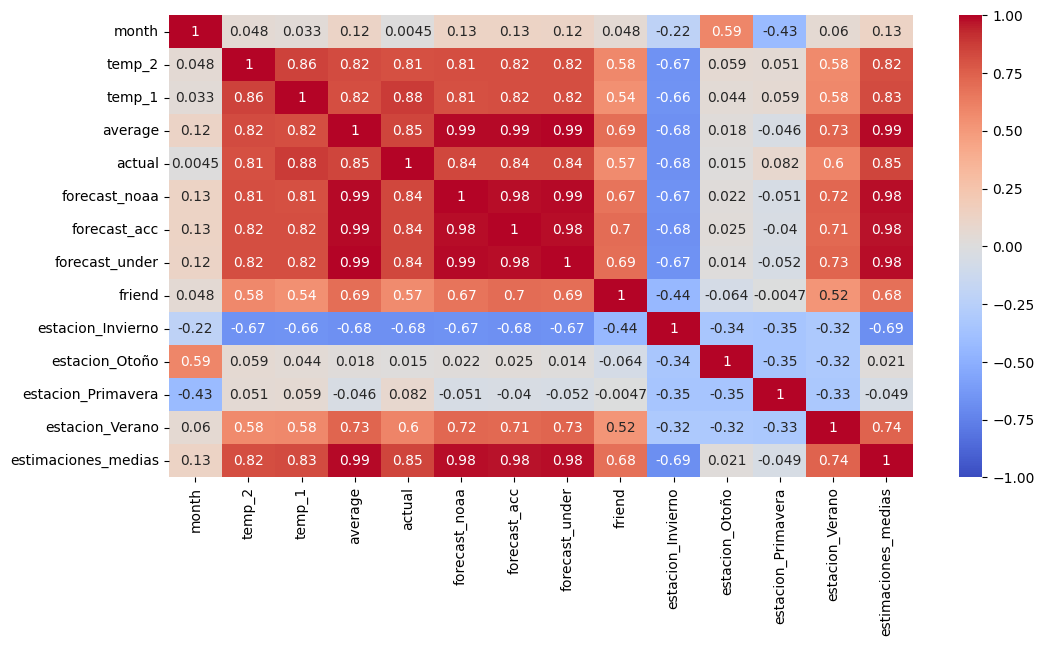

In [64]:
plt.figure(figsize=(12,6))
sns.heatmap(df.corr(),annot=True,vmin=-1,cmap="coolwarm")

In [67]:
df.drop(columns=["estacion_Otoño","estacion_Primavera"],inplace=True)

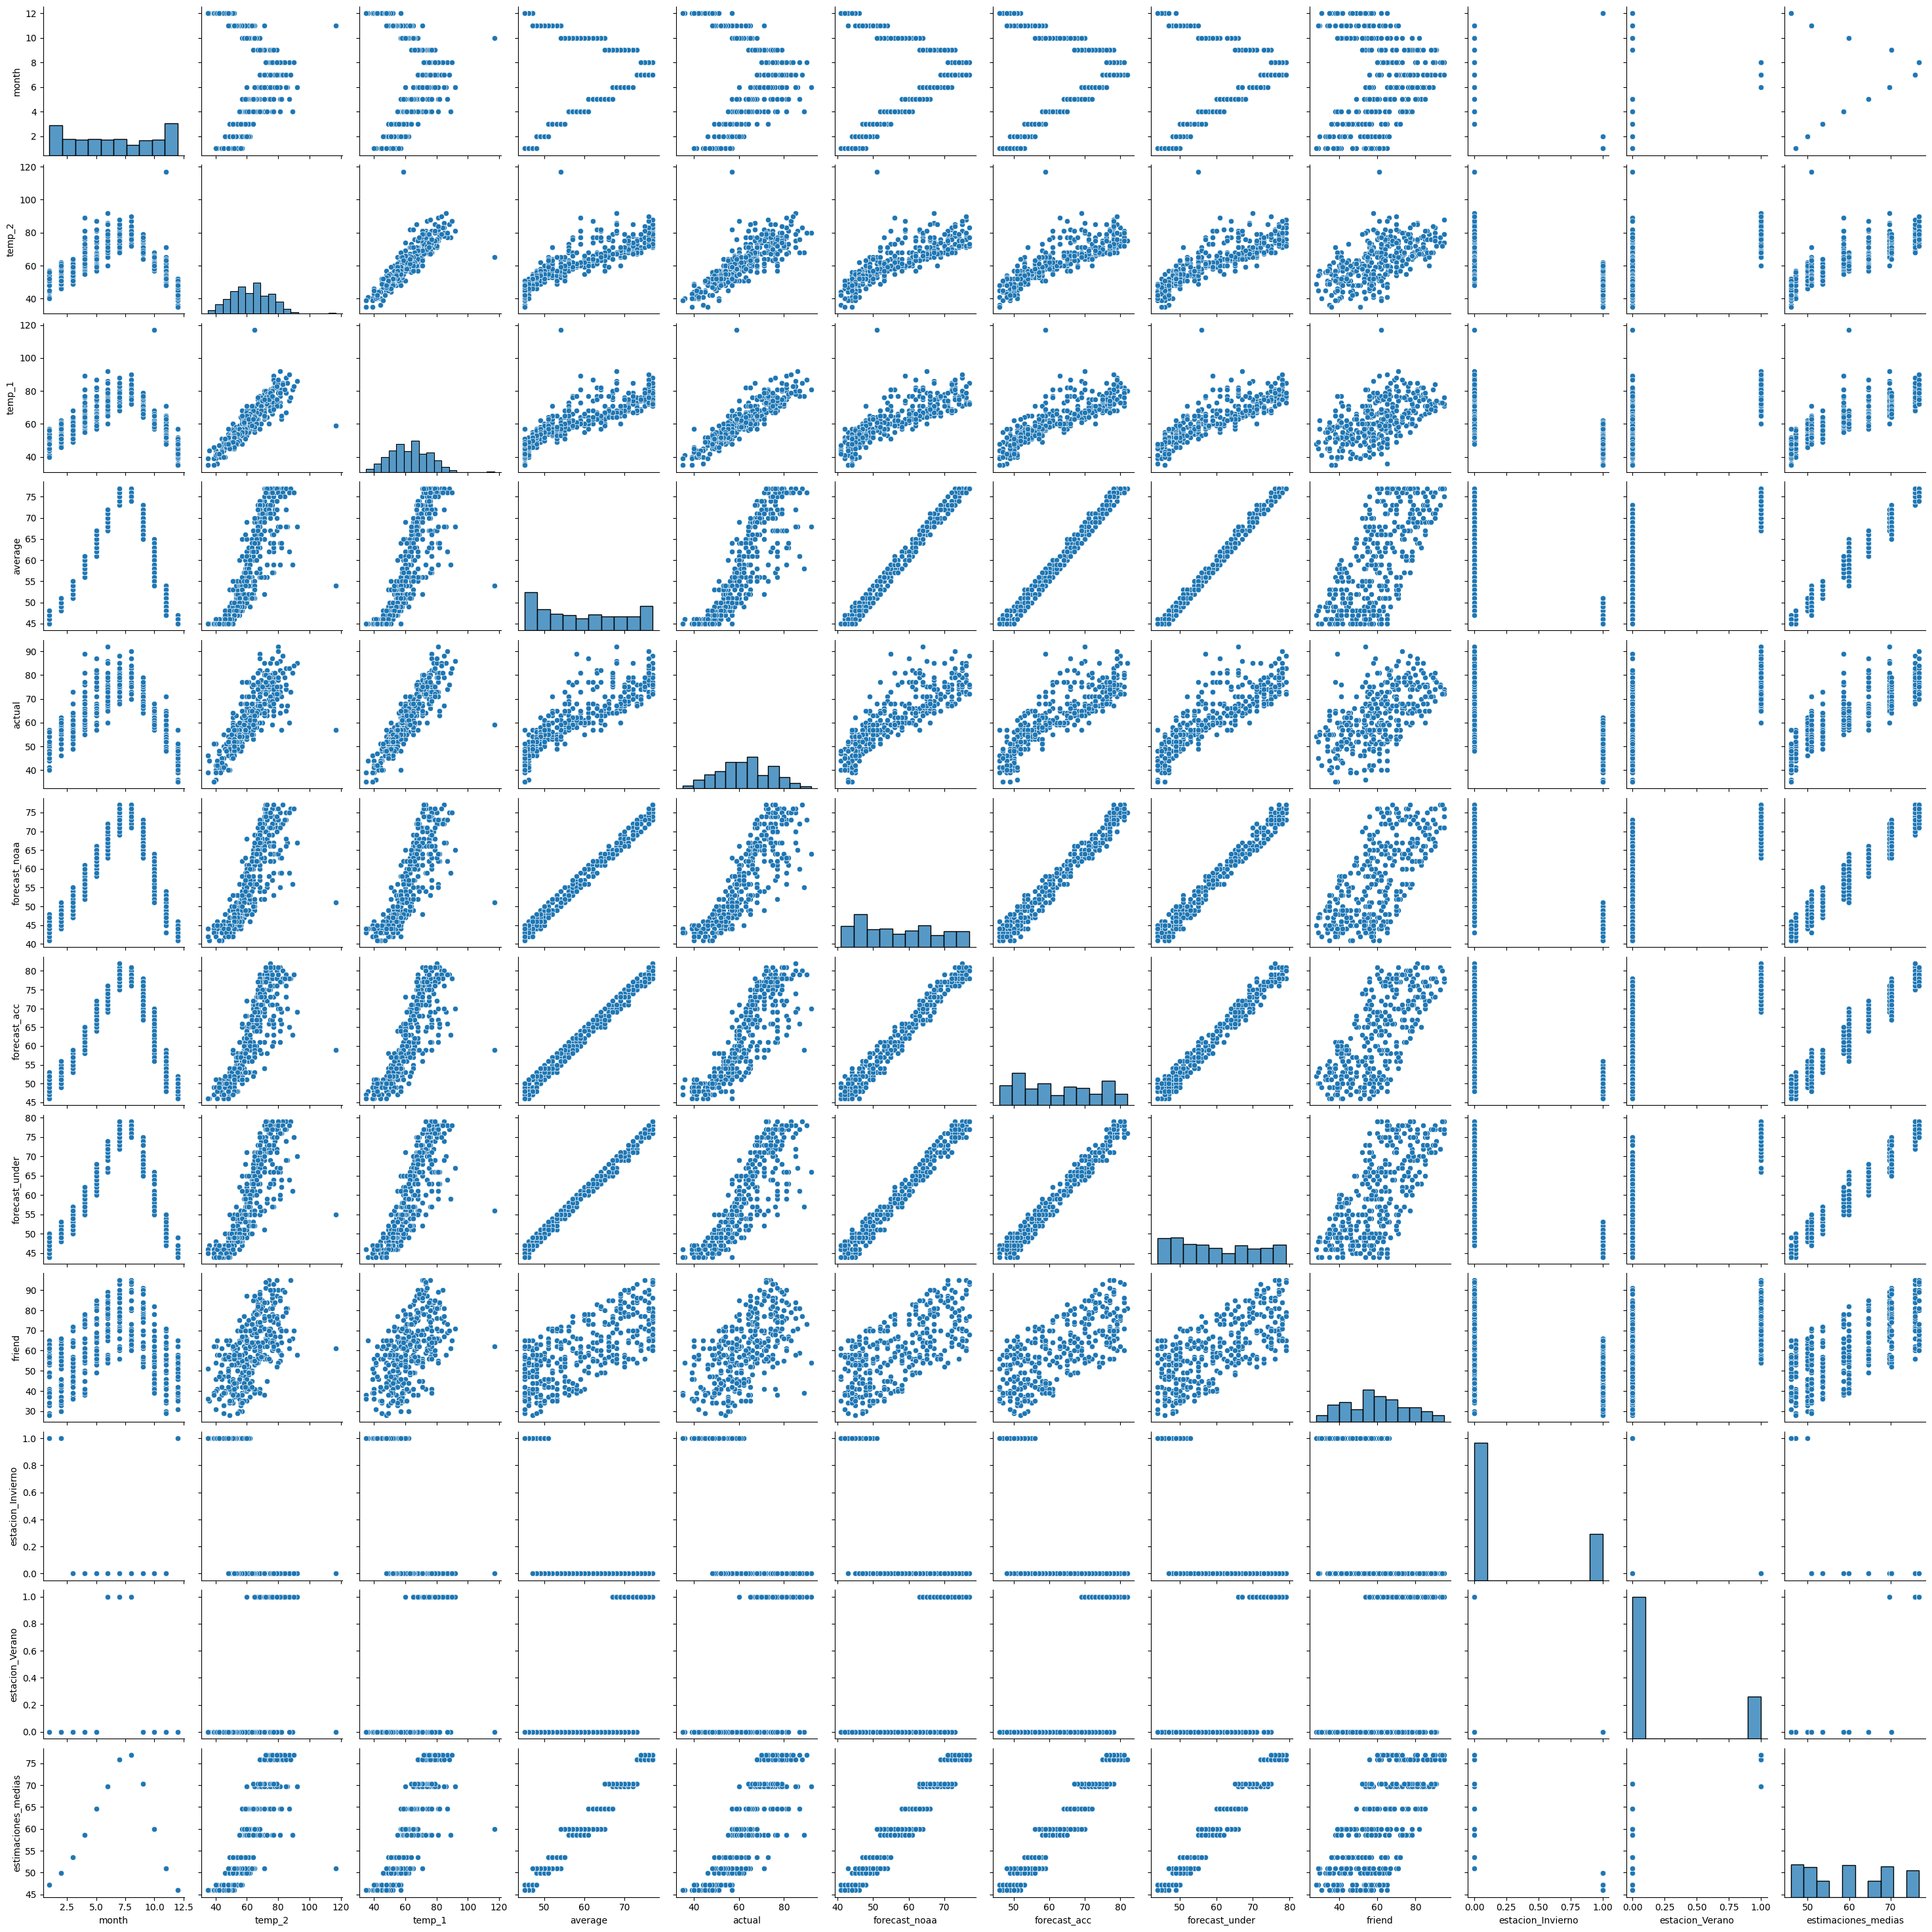

In [68]:
sns.pairplot(df)

### 3. Selecciona variables y divide en train y test

In [69]:
df.columns

Index(['month', 'temp_2', 'temp_1', 'average', 'actual', 'forecast_noaa',
       'forecast_acc', 'forecast_under', 'friend', 'estacion_Invierno',
       'estacion_Verano', 'estimaciones_medias'],
      dtype='object')

In [71]:
X = df[['month', 'temp_2', 'temp_1', 'average','forecast_noaa',
       'forecast_acc', 'forecast_under', 'friend', 'estacion_Invierno',
       'estacion_Verano', 'estimaciones_medias']]
y = df['actual']

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(278, 11)
(70, 11)
(278,)
(70,)


### 4. Entrena el modelo


In [126]:
modelo_1 = DecisionTreeRegressor(max_depth=5,min_samples_split=25,min_samples_leaf=10)
modelo_1.fit(X_train,y_train)

DecisionTreeRegressor(max_depth=5, min_samples_leaf=10, min_samples_split=25)

In [127]:
predicciones_iniciales = modelo_1.predict(X_test)

### 5. Evaluación de tu modelo
Calcula el coeficiente de determinación. 

Calcula el MAE, MAPE, MSE y RMSE.

In [128]:
print("R2 score", r2_score(y_test, predicciones_iniciales))
print("MSE", mean_squared_error(y_test, predicciones_iniciales))
print("MAE", mean_absolute_error(y_test, predicciones_iniciales))
print("RMSE", np.sqrt(mean_squared_error(y_test, predicciones_iniciales)))

R2 score 0.8302369704478251
MSE 23.73716757540722
MAE 3.8626249496454097
RMSE 4.872080415531667


### 6. Representa el árbol de decisión

[Text(0.4791666666666667, 0.9166666666666666, 'temp_1 <= 59.5\nsquared_error = 138.218\nsamples = 278\nvalue = 62.342'),
 Text(0.1875, 0.75, 'average <= 46.5\nsquared_error = 43.932\nsamples = 116\nvalue = 51.414'),
 Text(0.33333333333333337, 0.8333333333333333, 'True  '),
 Text(0.08333333333333333, 0.5833333333333334, 'temp_1 <= 46.5\nsquared_error = 23.35\nsamples = 33\nvalue = 43.727'),
 Text(0.041666666666666664, 0.4166666666666667, 'squared_error = 12.688\nsamples = 23\nvalue = 41.913'),
 Text(0.125, 0.4166666666666667, 'squared_error = 22.89\nsamples = 10\nvalue = 47.9'),
 Text(0.2916666666666667, 0.5833333333333334, 'temp_1 <= 55.5\nsquared_error = 19.285\nsamples = 83\nvalue = 54.47'),
 Text(0.20833333333333334, 0.4166666666666667, 'forecast_noaa <= 48.5\nsquared_error = 10.805\nsamples = 53\nvalue = 52.396'),
 Text(0.16666666666666666, 0.25, 'friend <= 54.5\nsquared_error = 7.056\nsamples = 36\nvalue = 51.333'),
 Text(0.125, 0.08333333333333333, 'squared_error = 5.675\nsamples

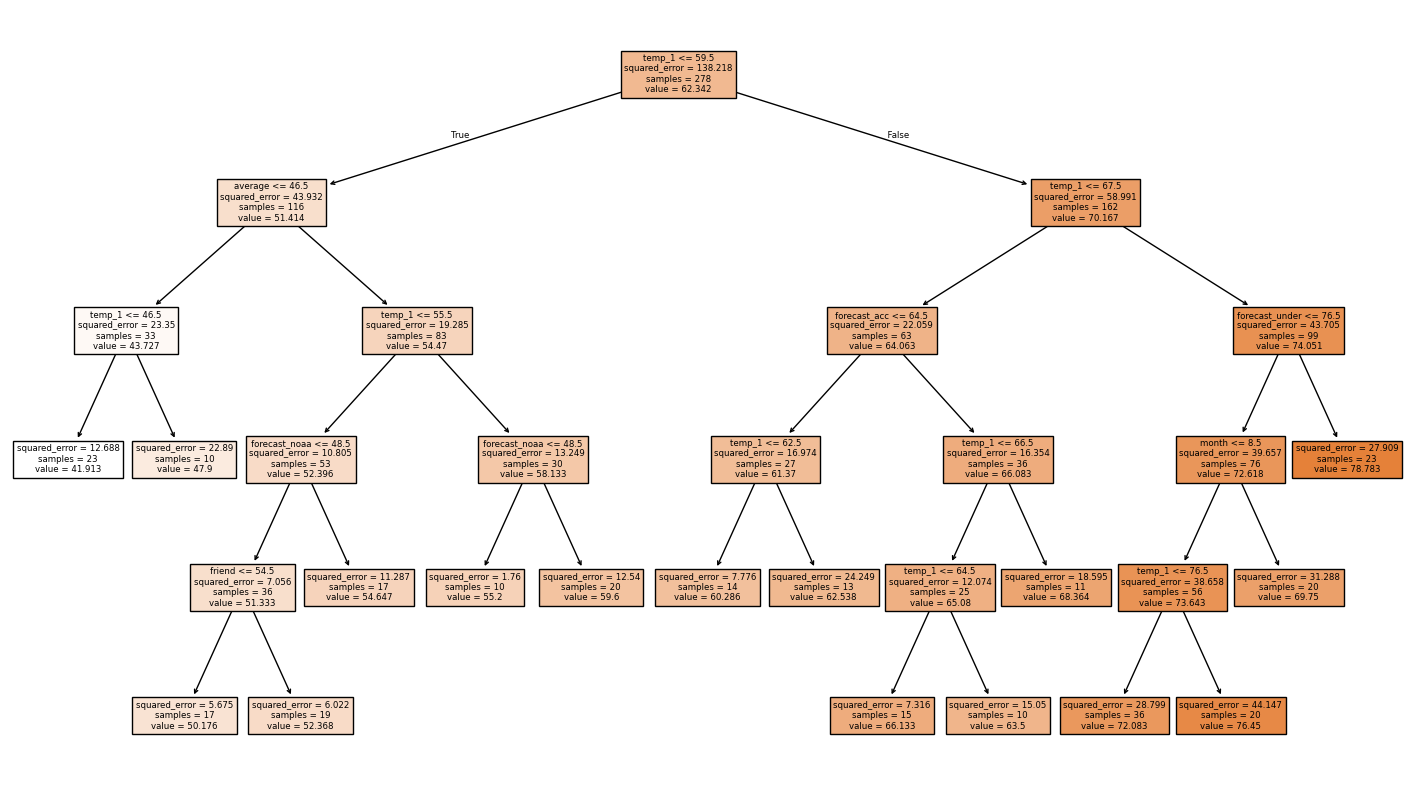

In [129]:
plt.figure(figsize=(18,10))
plot_tree(modelo_1, feature_names= X_train.columns.tolist(),filled = True)

### 7. Modifica el max_depth a 3 y vuelve a entrenarlo

In [96]:
modelo_2 = DecisionTreeRegressor(max_depth=3)
modelo_2.fit(X_train,y_train)

DecisionTreeRegressor(max_depth=3)

In [98]:
predicciones = modelo_2.predict(X_test)

### 8. Vuelve a evaluar tu modelo

In [99]:
print("R2 score", r2_score(y_test, predicciones))
print("MSE", mean_squared_error(y_test, predicciones))
print("MAE", mean_absolute_error(y_test, predicciones))
print("RMSE", np.sqrt(mean_squared_error(y_test, predicciones)))

R2 score 0.7585292488227066
MSE 33.76372170298277
MAE 4.419096047017553
RMSE 5.810655875456984


### 9. Vuelve a representar su árbol

[Text(0.5, 0.875, 'temp_1 <= 59.5\nsquared_error = 138.218\nsamples = 278\nvalue = 62.342'),
 Text(0.25, 0.625, 'average <= 46.5\nsquared_error = 43.932\nsamples = 116\nvalue = 51.414'),
 Text(0.375, 0.75, 'True  '),
 Text(0.125, 0.375, 'temp_1 <= 46.5\nsquared_error = 23.35\nsamples = 33\nvalue = 43.727'),
 Text(0.0625, 0.125, 'squared_error = 12.688\nsamples = 23\nvalue = 41.913'),
 Text(0.1875, 0.125, 'squared_error = 22.89\nsamples = 10\nvalue = 47.9'),
 Text(0.375, 0.375, 'temp_1 <= 55.5\nsquared_error = 19.285\nsamples = 83\nvalue = 54.47'),
 Text(0.3125, 0.125, 'squared_error = 10.805\nsamples = 53\nvalue = 52.396'),
 Text(0.4375, 0.125, 'squared_error = 13.249\nsamples = 30\nvalue = 58.133'),
 Text(0.75, 0.625, 'temp_1 <= 67.5\nsquared_error = 58.991\nsamples = 162\nvalue = 70.167'),
 Text(0.625, 0.75, '  False'),
 Text(0.625, 0.375, 'forecast_under <= 60.5\nsquared_error = 22.059\nsamples = 63\nvalue = 64.063'),
 Text(0.5625, 0.125, 'squared_error = 16.974\nsamples = 27\nvalue

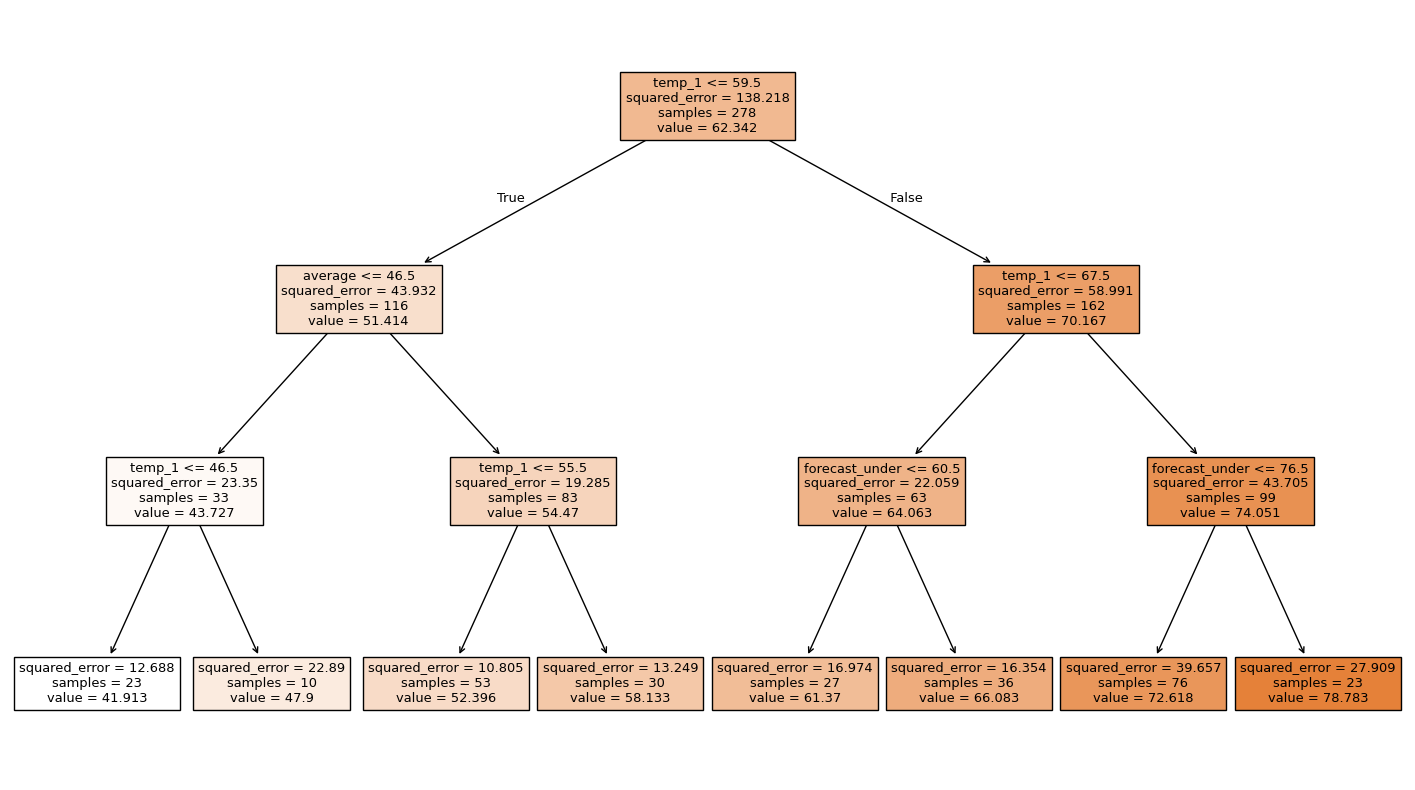

In [100]:
plt.figure(figsize=(18,10))
plot_tree(modelo_2, feature_names= X_train.columns.tolist(),filled = True)

### 10. Utiliza un grid search con cross validation para hiperparametrizar tu modelo

In [132]:
parametros = {"max_depth" : np.arange(1,10),"min_samples_split":np.arange(10,50,5),"min_samples_leaf":np.arange(10,50,5)}

gs = GridSearchCV(estimator=modelo_1, param_grid=parametros, cv=5, scoring='neg_mean_squared_error', verbose=2)
gs.fit(X_train, y_train)

print(gs.best_estimator_)
print(gs.best_score_)
print(gs.best_params_)

Fitting 5 folds for each of 576 candidates, totalling 2880 fits
[CV] END max_depth=1, min_samples_leaf=10, min_samples_split=10; total time=   0.0s
[CV] END max_depth=1, min_samples_leaf=10, min_samples_split=10; total time=   0.0s
[CV] END max_depth=1, min_samples_leaf=10, min_samples_split=10; total time=   0.0s
[CV] END max_depth=1, min_samples_leaf=10, min_samples_split=10; total time=   0.0s
[CV] END max_depth=1, min_samples_leaf=10, min_samples_split=10; total time=   0.0s
[CV] END max_depth=1, min_samples_leaf=10, min_samples_split=15; total time=   0.0s
[CV] END max_depth=1, min_samples_leaf=10, min_samples_split=15; total time=   0.0s
[CV] END max_depth=1, min_samples_leaf=10, min_samples_split=15; total time=   0.0s
[CV] END max_depth=1, min_samples_leaf=10, min_samples_split=15; total time=   0.0s
[CV] END max_depth=1, min_samples_leaf=10, min_samples_split=15; total time=   0.0s
[CV] END max_depth=1, min_samples_leaf=10, min_samples_split=20; total time=   0.0s
[CV] END max

In [134]:
modelo_final = gs.best_estimator_
modelo_final

DecisionTreeRegressor(max_depth=np.int64(4), min_samples_leaf=np.int64(10),
                      min_samples_split=np.int64(10))

In [135]:
predicciones_final = modelo_final.predict(X_test)

In [137]:
scaler = StandardScaler()

In [149]:
scores =cross_val_score(modelo_final, scaler.fit_transform(X), y, scoring='neg_mean_squared_error', cv= 10)
print(scores.mean())
print(scores.std())

-33.073150088951095
15.000574208173488


### 11. Obten el `feature_importances` de cada variable en el último modelo

In [140]:
modelo_final.feature_importances_

array([0.00674128, 0.        , 0.87268564, 0.08225347, 0.00772341,
       0.        , 0.0305962 , 0.        , 0.        , 0.        ,
       0.        ])

### 12. Construye un nuevo modelo `DecisionTreeClassifier` que te clasifique cuando en un día va a hacer una temperatura mayor a 15ºC. ¡Deberá tratarse como un problema de **clasificación**! Utiliza un grid search con cross validation y evalúa el mejor modelo.

In [151]:
lista_rangos = []
for x in df["actual"]:
    if x >59:
        lista_rangos.append(1)
    else:
        lista_rangos.append(0)


In [152]:
df["target"] = lista_rangos

In [153]:
X = df[['month', 'temp_2', 'temp_1', 'average','forecast_noaa',
       'forecast_acc', 'forecast_under', 'friend', 'estacion_Invierno',
       'estacion_Verano', 'estimaciones_medias']]
y = df['target']

In [154]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(278, 11)
(70, 11)
(278,)
(70,)


In [155]:
modelo_clas = DecisionTreeClassifier(max_depth=3)
modelo_clas.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=3)

In [157]:
parametros = {"max_depth" : np.arange(1,10),"min_samples_split":np.arange(10,50,5),"min_samples_leaf":np.arange(10,50,5),"criterion":["gini","entropy"]}

gs = GridSearchCV(estimator=modelo_clas, param_grid=parametros, cv=5, scoring='accuracy', verbose=2)
gs.fit(X_train, y_train)

print(gs.best_estimator_)
print(gs.best_score_)
print(gs.best_params_)

Fitting 5 folds for each of 1152 candidates, totalling 5760 fits
[CV] END criterion=gini, max_depth=1, min_samples_leaf=10, min_samples_split=10; total time=   0.0s
[CV] END criterion=gini, max_depth=1, min_samples_leaf=10, min_samples_split=10; total time=   0.0s
[CV] END criterion=gini, max_depth=1, min_samples_leaf=10, min_samples_split=10; total time=   0.0s
[CV] END criterion=gini, max_depth=1, min_samples_leaf=10, min_samples_split=10; total time=   0.0s
[CV] END criterion=gini, max_depth=1, min_samples_leaf=10, min_samples_split=10; total time=   0.0s
[CV] END criterion=gini, max_depth=1, min_samples_leaf=10, min_samples_split=15; total time=   0.0s
[CV] END criterion=gini, max_depth=1, min_samples_leaf=10, min_samples_split=15; total time=   0.0s
[CV] END criterion=gini, max_depth=1, min_samples_leaf=10, min_samples_split=15; total time=   0.0s
[CV] END criterion=gini, max_depth=1, min_samples_leaf=10, min_samples_split=15; total time=   0.0s
[CV] END criterion=gini, max_depth=

In [158]:
modelo_clas_final = gs.best_estimator_
predicciones_class_final = modelo_clas_final.predict(X_test)

In [161]:
print(f1_score(y_test,predicciones_class_final))
print(precision_score(y_test,predicciones_class_final))
print(recall_score(y_test,predicciones_class_final))

0.9397590361445783
0.9512195121951219
0.9285714285714286


### 13. Construye un nuevo modelo `RandomForestClassifier` que te clasifique cuando en un día va a hacer una temperatura mayor a 15ºC. ¡Deberá tratarse como un problema de **clasificación**! Utiliza un grid search con cross validation y evalúa el mejor modelo.

In [163]:
modelo_RF = RandomForestClassifier(max_depth=3)
modelo_RF.fit(X_train,y_train)

RandomForestClassifier(max_depth=3)

In [168]:
parametros = {"n_estimators":[100,200,300],"max_depth" : np.arange(1,5),"min_samples_split":np.arange(10,50,5),"min_samples_leaf":np.arange(10,50,5)}

gs = GridSearchCV(estimator=modelo_RF, param_grid=parametros, cv=5, scoring='accuracy', verbose=2)
gs.fit(X_train, y_train)

print(gs.best_estimator_)
print(gs.best_score_)
print(gs.best_params_)

Fitting 5 folds for each of 768 candidates, totalling 3840 fits
[CV] END max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=100; total time=   0.0s
[CV] END max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=100; total time=   0.0s
[CV] END max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=100; total time=   0.0s
[CV] END max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=100; total time=   0.0s
[CV] END max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=100; total time=   0.0s
[CV] END max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=200; total time=   0.1s
[CV] END max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=200; total time=   0.1s
[CV] END max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=200; total time=   0.1s
[CV] END max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=200; total time=   0.1s
[CV] END max_depth

In [169]:
modelo_RF_final = gs.best_estimator_
pred = modelo_RF_final.predict(X_test)

In [170]:
print(f1_score(y_test,pred))
print(precision_score(y_test,pred))
print(recall_score(y_test,pred))

0.9411764705882353
0.9302325581395349
0.9523809523809523
